In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.utils import shuffle
from sklearn import linear_model, preprocessing
from datetime import datetime
import sklearn.model_selection
import pickle
from matplotlib import style
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

**Data Wrangling**

 Since the production data are measured between Janurary 2015 and December 2020 every month, I transform the data of the predictor variables (precipitation, soil moisture, temperature, NDVI) by getting their monthly average data in the same interval. Then, I unify the datasets for efficient access and analysis. 

In [2]:
# Precipitation
url = 'https://raw.githubusercontent.com/haechan01/Grople-syrup-production-quantity-prediction/master/Daily%20Precipitation.csv'
precipitation = pd.read_csv(url)

# creates a new dataframe for the model: precipitation data between Janurary 2015 and January 2021
precip_model_df = precipitation.drop(precipitation[precipitation.start_date < '2015-01-01'].index)
precip_model_df = precip_model_df.drop(precip_model_df[precip_model_df.start_date > '2021-01-01'].index)

# makes sure indexes pair with number of rows
precip_model_df = precip_model_df.reset_index()
precip_model_df=precip_model_df.drop(columns=['index'])

# Converts the measurement time to monthly form
precip_model_df['start_date'] = pd.PeriodIndex(precip_model_df['start_date'], freq="M")
precip_model_df['end_date'] = pd.PeriodIndex(precip_model_df['end_date'], freq="M")

region_IDs = [93,94,95,97,98,99,102,103,104,105]
regions=[]
monthly_precipitation=[]
soil_moisture = []


for i in region_IDs:
  region = precip_model_df[precip_model_df['region_id']==i]

  # groups all the data in a month and calculates the average soil moisture for the month
  average_precipitation=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['precip'].mean()
  # groups all the region ID of a month
  region_id=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['region_id'].mean()

  # add the average soil moisture and their region ID to the lists
  monthly_precipitation.append(average_precipitation)
  regions.append(region_id)

# monthly period range between January 2015 and March 2022, which repeats 10 times for the 10 regions
time = [pd.period_range('2015-01', periods=75, freq='M')]*10

# parses through the month, region id, and monthly average precipitation data 
for i in range(len(regions)):  # index for region id
  for j in range(len(regions[i])):  # index for monthly data of the region
    soil_moisture.append([time[i][j],regions[i][j],monthly_precipitation[i][j]])

# creates pandas dataframe with the list created above
precip_model_df = pd.DataFrame(soil_moisture, columns =['time','Region_Id', 'Mean_precip'])
by_months = []
precip_model_df['time'] = precip_model_df['time'].astype(str)
for i in range(len(precip_model_df['time'])):
  month=precip_model_df['time'][i].split('-')[1]
  by_months.append(month)
monthly = pd.DataFrame(by_months, columns =['months'])
months= monthly['months']
precip_model_df=precip_model_df.join(months)
precip_model_df['months'] = precip_model_df['months'].astype(int)
precip_model_df

,time,Region_Id,Mean_precip,months
0,2015-01,93,4.394452,1
1,2015-02,93,1.206137,2
2,2015-03,93,3.454652,3
3,2015-04,93,10.466472,4
4,2015-05,93,9.007986,5
...,...,...,...,...
715,2020-08,105,7.635350,8
716,2020-09,105,6.852630,9
717,2020-10,105,11.276676,10
718,2020-11,105,17.676531,11


In [3]:
# Soil Mositure
url = 'https://raw.githubusercontent.com/haechan01/Grople-syrup-production-quantity-prediction/master/Daily%20Soil%20Mositure.csv'
soil_moisture = pd.read_csv(url)

# creates a new dataframe for the model: soil moisture data between Janurary 2015 and January 2021
smos_model_df = soil_moisture.drop(soil_moisture[soil_moisture.start_date < '2015-01-01'].index)
smos_model_df = smos_model_df.drop(smos_model_df[smos_model_df.start_date > '2021-01-01'].index)

# makes sure indexes pair with number of rows
smos_model_df = smos_model_df.reset_index()
smos_model_df=smos_model_df.drop(columns=['index'])

# Converts the measurement time to monthly form
smos_model_df['start_date'] = pd.PeriodIndex(smos_model_df['start_date'], freq="M")
smos_model_df['end_date'] = pd.PeriodIndex(smos_model_df['end_date'], freq="M")

region_IDs = [93,94,95,97,98,99,102,103,104,105]
regions=[]
monthly_smos=[]
smos_data = []


for i in region_IDs:
  region = smos_model_df[smos_model_df['region_id']==i]

  # groups all the data in a month and calculates the average soil moisture for the month
  average_smos=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['smos'].mean()
  # groups all the region ID of a month
  region_id=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['region_id'].mean()

  # add the average soil moisture and their region ID to the lists
  monthly_smos.append(average_smos)
  regions.append(region_id)

# monthly period range between January 2015 and March 2022, which repeats 10 times for the 10 regions
monthes = [pd.period_range('2015-01', periods=75, freq='M')]*10

# parses through the month, region id, and monthly average smos data 
for i in range(len(regions)):  # index for region id
  for j in range(len(regions[i])):  # index for monthly data of the region
    smos_data.append([monthes[i][j],regions[i][j],monthly_smos[i][j]])

# creates pandas dataframe with the list created above
smos_model_df = pd.DataFrame(smos_data, columns =['monthes','Region_Id', 'Mean_smos'])
smos_model_df

,monthes,Region_Id,Mean_smos
0,2015-01,93,0.318552
1,2015-02,93,0.291452
2,2015-03,93,0.251969
3,2015-04,93,0.248915
4,2015-05,93,0.280602
...,...,...,...
715,2020-08,105,0.225784
716,2020-09,105,0.277477
717,2020-10,105,0.277670
718,2020-11,105,0.302014


In [4]:
# Temperature
url = 'https://raw.githubusercontent.com/haechan01/Grople-syrup-production-quantity-prediction/master/Daily%20Temperature.csv'
Temperature = pd.read_csv(url)
# creates a new dataframe for the model: Temperature data between Janurary 2015 and January 2021
temp_model_df = Temperature.drop(Temperature[Temperature.start_date < '2015-01-01'].index)
temp_model_df = temp_model_df.drop(temp_model_df[temp_model_df.start_date > '2021-01-01'].index)

# makes sure indexes pair with number of rows
temp_model_df = temp_model_df.reset_index()
temp_model_df=temp_model_df.drop(columns=['index'])

# Converts the measurement time to monthly form
temp_model_df['start_date'] = pd.PeriodIndex(temp_model_df['start_date'], freq="M")
temp_model_df['end_date'] = pd.PeriodIndex(temp_model_df['end_date'], freq="M")

region_IDs = [93,94,95,97,98,99,102,103,104,105]
regions=[]
monthly_Temperature=[]
smos_data = []

for i in region_IDs:
  region = temp_model_df[temp_model_df['region_id']==i]
  # groups all the data in a month and calculates the average soil moisture for the month
  average_Temperature=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['temp'].mean()
  # groups all the region ID of a month
  region_id=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['region_id'].mean()
  # add the average soil moisture and their region ID to the lists
  monthly_Temperature.append(average_Temperature)
  regions.append(region_id)

# monthly period range between January 2015 and March 2022, which repeats 10 times for the 10 regions
monthes = [pd.period_range('2015-01', periods=72, freq='M')]*10

# parses through the month, region id, and monthly average Temperature data 
for i in range(len(regions)):  # index for region id
  for j in range(len(regions[i])):  # index for monthly data of the region
    smos_data.append([monthes[i][j],regions[i][j],monthly_Temperature[i][j]])

# creates pandas dataframe with the list created above
temp_model_df = pd.DataFrame(smos_data, columns =['monthes','Region_Id', 'Mean_temp'])
temp_model_df

,monthes,Region_Id,Mean_temp
0,2015-01,93,25.003593
1,2015-02,93,26.807568
2,2015-03,93,26.954109
3,2015-04,93,26.948865
4,2015-05,93,25.405121
...,...,...,...
715,2020-08,105,27.424585
716,2020-09,105,27.940492
717,2020-10,105,27.048770
718,2020-11,105,24.715070


In [5]:
# 
url = 'https://raw.githubusercontent.com/haechan01/Grople-syrup-production-quantity-prediction/master/Eight%20Day%20NDVI.csv'
NDVI = pd.read_csv(url)
# creates a new dataframe for the model: precipitation data between Janurary 2015 and January 2021
NDVI_model_df = NDVI.drop(NDVI[NDVI.start_date < '2015-01-01'].index)
NDVI_model_df = NDVI_model_df.drop(NDVI_model_df[NDVI_model_df.start_date > '2021-01-01'].index)

# makes sure indexes pair with number of rows
NDVI_model_df = NDVI_model_df.reset_index()
NDVI_model_df=NDVI_model_df.drop(columns=['index'])
# Converts the measurement time to monthly form
NDVI_model_df['start_date'] = pd.PeriodIndex(NDVI_model_df['start_date'], freq="M")
NDVI_model_df['end_date'] = pd.PeriodIndex(NDVI_model_df['end_date'], freq="M")

region_IDs = [93,94,95,97,98,99,102,103,104,105]
regions=[]
monthly_precipitation=[]
ndvi_data = []


for i in region_IDs:
  region = NDVI_model_df[NDVI_model_df['region_id']==i]

  # groups all the data in a month and calculates the average ndvi for the month
  average_precipitation=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['ndvi'].mean()
  # groups all the region ID of a month
  region_id=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['region_id'].mean()

  # add the average ndvi and their region ID to the lists
  monthly_precipitation.append(average_precipitation)
  regions.append(region_id)

# monthly period range between January 2015 and March 2022, which repeats 10 times for the 10 regions
monthes = [pd.period_range('2015-01', periods=72, freq='M')]*10

# parses through the month, region id, and monthly average precipitation data 
for i in range(len(regions)):  # index for region id
  for j in range(len(regions[i])):  # index for monthly data of the region
    ndvi_data.append([monthes[i][j],regions[i][j],monthly_precipitation[i][j]])

NDVI_model_df = pd.DataFrame(ndvi_data, columns =['monthes','Region_Id', 'Mean_ndvi'])
here = []
for i in range(len(monthes)):
  for j in range(len(monthes[i])):
    if monthes[i][j]== NDVI_model_df['monthes'][j]:
      here.append(1) 
      
date1 = pd.to_datetime([datetime(2020, 11, 1)])
date2 = pd.to_datetime([datetime(2020, 12, 1)])

# NDVI_model_df = NDVI_model_df.sort_index().reset_index(drop=True)
df_update = pd.DataFrame(dict(monthes=[date2.to_period('M')[0],date2.to_period('M')[0],date1.to_period('M')[0],date2.to_period('M')[0]], Region_Id = [97,104,105,105],Mean_ndvi= [(0.8028292+0.819865)/2,0.7908089,(0.803924+0.80246)/2,(0.77831+0.803472)/2]), index=[287, 646, 716,718])
NDVI_model_df = pd.concat([df_update,NDVI_model_df],axis=0)
NDVI_model_df.sort_index(inplace=True)
NDVI_model_df = NDVI_model_df.reset_index()
NDVI_model_df=NDVI_model_df.drop(columns=['index'])
NDVI_model_df

,monthes,Region_Id,Mean_ndvi
0,2015-01,93,0.761228
1,2015-02,93,0.758957
2,2015-03,93,0.752754
3,2015-04,93,0.785057
4,2015-05,93,0.805262
...,...,...,...
715,2020-08,105,0.815188
716,2020-09,105,0.803192
717,2020-10,105,0.790891
718,2020-11,105,0.803192


In [6]:
# Production Quantity
url = 'https://raw.githubusercontent.com/haechan01/Grople-syrup-production-quantity-prediction/master/Production%20Quantity.csv'
production = pd.read_csv(url)
start_date = production['start_date'].apply(lambda x: x.split('T')[0])
end_date = production['end_date'].apply(lambda x: x.split('T')[0])
production['start_date']= start_date
production['end_date'] =end_date
production.rename(columns = {'prod':'production'}, inplace = True)
production

,start_date,end_date,production,region_id
0,2015-01-01,2015-01-31,171725,93
1,2015-02-01,2015-02-28,188325,93
2,2015-03-01,2015-03-31,247856,93
3,2015-04-01,2015-04-30,282791,93
4,2015-05-01,2015-05-31,291057,93
...,...,...,...,...
715,2020-08-01,2020-08-31,57818,105
716,2020-09-01,2020-09-30,57474,105
717,2020-10-01,2020-10-31,51821,105
718,2020-11-01,2020-11-30,44947,105


In [7]:

soil_moistures= smos_model_df['Mean_smos']
temperature = temp_model_df['Mean_temp']
ndvi = NDVI_model_df['Mean_ndvi']
productions = production['production']
monthly = pd.DataFrame(by_months, columns =['months'])
months= monthly['months']
df = precip_model_df.join(soil_moistures).join(temperature).join(ndvi).join(productions)
df['Region_Id'] = df['Region_Id'].astype(int)
df['Region_Id'] = df['Region_Id'].astype(str)
df['months'] = df['months'].astype(str)
df


,time,Region_Id,Mean_precip,months,Mean_smos,Mean_temp,Mean_ndvi,production
0,2015-01,93,4.394452,1,0.318552,25.003593,0.761228,171725
1,2015-02,93,1.206137,2,0.291452,26.807568,0.758957,188325
2,2015-03,93,3.454652,3,0.251969,26.954109,0.752754,247856
3,2015-04,93,10.466472,4,0.248915,26.948865,0.785057,282791
4,2015-05,93,9.007986,5,0.280602,25.405121,0.805262,291057
...,...,...,...,...,...,...,...,...
715,2020-08,105,7.635350,8,0.225784,27.424585,0.815188,57818
716,2020-09,105,6.852630,9,0.277477,27.940492,0.803192,57474
717,2020-10,105,11.276676,10,0.277670,27.048770,0.790891,51821
718,2020-11,105,17.676531,11,0.302014,24.715070,0.803192,44947


**Exploratory Data Analysis**

In [8]:
df[["Mean_precip","Mean_smos","Mean_temp","Mean_ndvi","production"]].describe()

,Mean_precip,Mean_smos,Mean_temp,Mean_ndvi,production
count,720.000000,720.000000,720.000000,720.000000,720.000000
mean,7.102879,0.260234,26.761042,0.799471,159014.201389
std,3.563283,0.067801,1.614798,0.028660,142882.722751
min,0.177770,0.070654,22.743680,0.617915,10215.000000
25%,4.482561,0.211360,25.566755,0.788075,35445.500000
50%,6.758597,0.262899,26.780220,0.805671,91945.500000
75%,9.171629,0.307856,27.921739,0.818483,269946.000000
max,21.202553,0.428933,32.049534,0.846443,593579.000000


From the statistics summary above, we can see that all the variables have 720 sample size. The standard deviation for the grople syrup production quantity is large (142882) when comepared to its mean.(158914). 

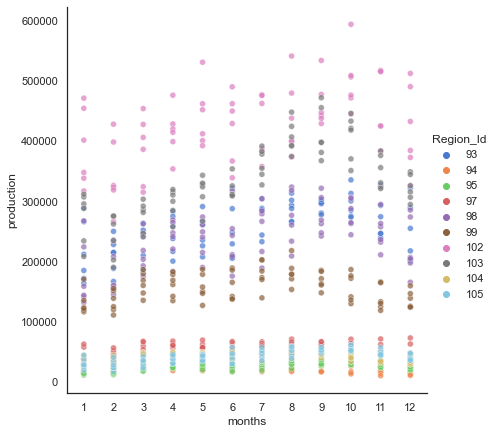

In [9]:
# production quantity by months

sns.set_theme(style="white")
g = sns.relplot(x="months", y="production", hue="Region_Id",
            sizes=(40, 400), alpha=.7, palette="muted",
            height=6, data=df)


<ipython-input-10-e89ba54037a4>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90) # set new labels


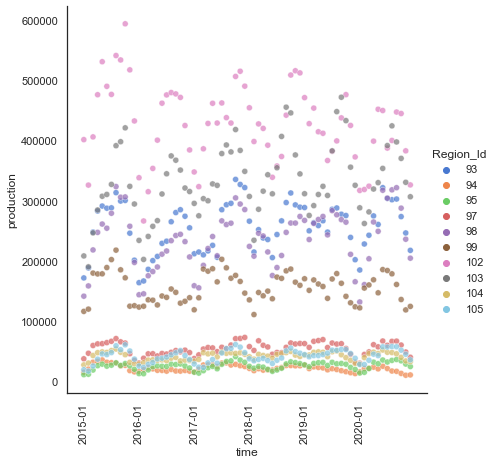

In [10]:
# monthly average of daily grople syrup production quantity
sns.set_theme(style="white")

plot = sns.relplot(x="time", y="production", hue="Region_Id", sizes=(40, 400), alpha=.7, palette="muted",height=6, data=df)
# plot.set(xticks=df.time[2015::2020])
for ax in plot.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i!= 0 and i!=12 and i!=24 and i!=36 and i!=48 and i!=60 and i!=72): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=90) # set new labels
plt.show()
#[plt.setp(ax.get_xticklabels(), rotation=90) for ax in plot.axes.flat]

From the two scatter plots above, we can find two key patterns. 1. Different regions have significantly different production quantity. 2. The production quantity tend to be higher around late summer and fall. In order to build a good model, we should take both of these features int account.  

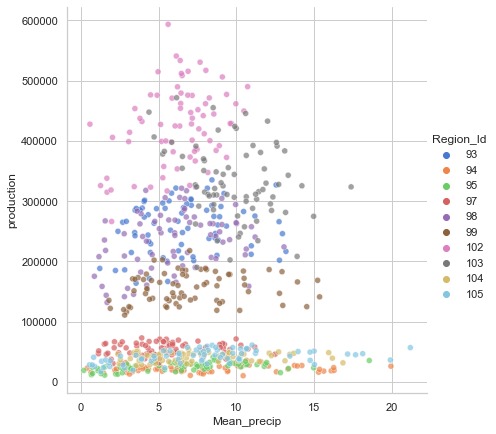

In [11]:
sns.set_theme(style="whitegrid")

sns.relplot(x="Mean_precip", y="production", hue="Region_Id",
            sizes=(40, 400), alpha=.7, palette="muted",
            height=6, data=df)

(<seaborn.axisgrid.FacetGrid at 0x7fb5917b4190>,)

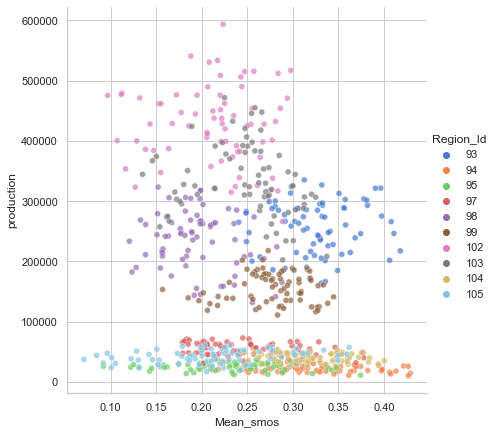

In [12]:
sns.set_theme(style="whitegrid")

sns.relplot(x="Mean_smos", y="production", hue="Region_Id",sizes=(40, 400), alpha=.7, palette="muted", height=6, data=df),

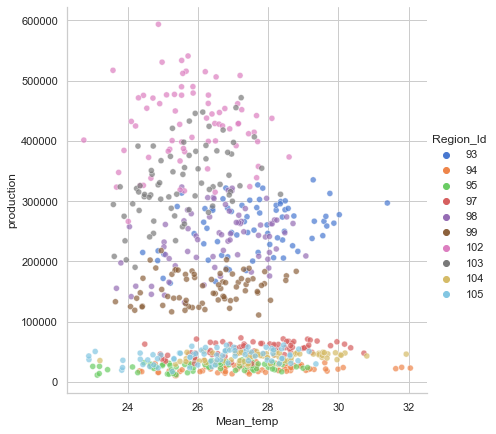

In [13]:
sns.set_theme(style="whitegrid")

sns.relplot(x="Mean_temp", y="production", hue="Region_Id",
            sizes=(40, 400), alpha=.7, palette="muted",
            height=6, data=df)

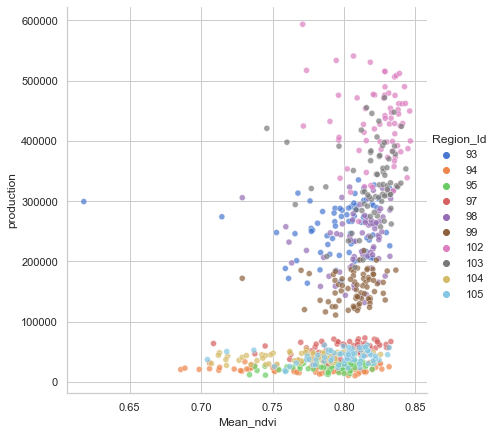

In [14]:
sns.set_theme(style="whitegrid")

sns.relplot(x="Mean_ndvi", y="production", hue="Region_Id",
            sizes=(40, 400), alpha=.7, palette="muted",
            height=6, data=df)

From the scatter plot above, we can see that there is no strong correlation between the variables and production quantity. We can also see two clusters of regions; a cluster above 100,000 and and below 100,000. We can also see that in the histogram below that the majority of the data are between 0 and 100,000 and the rest are distributed around 300,000. Thus, it seems important to take account of the categorical variable 'region_id' when using machine learning model to make a prediction. 

<AxesSubplot:>

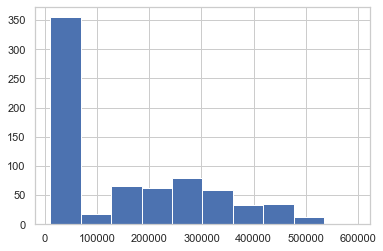

In [15]:
# histogram of grople syrup production quanitty
df.production.hist()

**Use Machine learning to make prediction**

In [16]:
# Random forest regression model

df = precip_model_df.join(soil_moistures).join(temperature).join(ndvi).join(productions)
predict = "production"
X = df[['Region_Id','Mean_ndvi','Mean_temp','Mean_smos','months','Mean_precip']]
# gets dummy variables for the categorical region id variable and drops a column to avoid dummy variable trap
X = pd.get_dummies(data=X, drop_first=True)
y = df['production']
y = np.array(df[predict])

best = 0
for i in range(30):
    X_train, X_test, y_train,  y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    regressor = RandomForestRegressor(n_estimators=10)
    regressor.fit(X_train, y_train) 
    y_pred = regressor.predict(X_test)
    # accuracy
    acc = r2_score(y_test,y_pred)
    if acc>best:
        best = acc
        with open("studentmodel.pickle", "wb") as f:
            pickle.dump(regressor, f)



pickle_in = open("studentmodel.pickle", "rb")
base_regressor = pickle.load(pickle_in)

predictions = regressor.predict(X_test)
print("Accuracy: ", best)


Accuracy:  0.9557159627982058


In [18]:
# hyper parameter tuning using random search with cross validation

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [19]:
# Uses the random grid to search for best hyperparameters
# Creates the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 20 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 20, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [20]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

In [21]:
# Random forest regression model using the best random search parameters

df = precip_model_df.join(soil_moistures).join(temperature).join(ndvi).join(productions)
predict = "production"
X = df[['Region_Id','Mean_ndvi','Mean_temp','Mean_smos','months','Mean_precip']]
# gets dummy variables for the categorical region id variable and drops a column to avoid dummy variable trap
X = pd.get_dummies(data=X, drop_first=True)
y = df['production']
y = np.array(df[predict])

best = 0
for i in range(30):
    X_train, X_test, y_train,  y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    regressor = RandomForestRegressor(n_estimators=800, max_depth=100, min_samples_leaf=1, min_samples_split=2)
    regressor.fit(X_train, y_train) 
    y_pred = regressor.predict(X_test)
    # accuracy
    acc = r2_score(y_test,y_pred)
    if acc>best:
        best = acc
        with open("studentmodel.pickle", "wb") as f:
            pickle.dump(regressor, f)



pickle_in = open("studentmodel.pickle", "rb")
regressor = pickle.load(pickle_in)

predictions = regressor.predict(X_test)
print("R2 score: ", best)


R2 score:  0.9647607818148635


In [22]:
# model evaluation function that calculates accuracy 
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [23]:
# accuracy of the new model with updated hyperparameters
evaluate(regressor, X_test, y_test)

Model Performance
Average Error: 10522.1703 degrees.
Accuracy = 89.32%.


89.32004202260546

In [24]:
# base model
base_regressor.fit(X_train, y_train)
base_accuracy = evaluate(base_regressor, X_test, y_test)

Model Performance
Average Error: 23171.8979 degrees.
Accuracy = 79.32%.


**Predict Grople syrub production quantity of 2021 using the model**

In [26]:
# creates a new dataframe to use for yhe precition of Grople syrup production in 2021
precip_predict_df = precipitation.drop(precipitation[precipitation.start_date < '2021-01-01'].index)
precip_predict_df = precip_predict_df.drop(precipitation[precipitation.start_date > '2022-01-01'].index)


# makes sure indexes pair with number of rows
precip_predict_df = precip_predict_df.reset_index()
precip_predict_df=precip_predict_df.drop(columns=['index'])

# Converts the time measurement time to monthly form
precip_predict_df['start_date'] = pd.PeriodIndex(precip_predict_df['start_date'], freq="M")
precip_predict_df['end_date'] = pd.PeriodIndex(precip_predict_df['end_date'], freq="M")

regions = [93,94,95,97,98,99,102,103,104,105]
monthly_regions=[]
monthly_precipitation=[]
precipitation_data = []


for i in regions:
  region = precip_predict_df[precip_predict_df['region_id']==i]

  # groups all the data in a month and calculates the average soil moisture for the month
  average_precipitation=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['precip'].mean()
  # groups all the region ID of a month
  region_id=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['region_id'].mean()

  # add the average soil moisture and their region ID to the lists
  monthly_precipitation.append(average_precipitation)
  monthly_regions.append(region_id)

# monthly period range between January 2015 and March 2022, which repeats 10 times for the 10 regions
monthes = [pd.period_range('2021-01', periods=12, freq='M')]*10

# parses through the month, region id, and monthly average precipitation data 
for i in range(len(monthly_regions)):  # index for region id
  for j in range(len(monthly_regions[i])):  #index for monthly data of the region
    precipitation_data.append([monthes[i][j],monthly_regions[i][j],monthly_precipitation[i][j]])

# creates pandas dataframe with the list created above
precip_predict_df = pd.DataFrame(precipitation_data, columns =['monthes','Region_Id', 'Mean_precip'])
precip_predict_df

,monthes,Region_Id,Mean_precip
0,2021-01,93,15.395451
1,2021-02,93,0.478108
2,2021-03,93,6.838074
3,2021-04,93,8.185650
4,2021-05,93,8.845651
...,...,...,...
115,2021-08,105,7.829626
116,2021-09,105,8.859617
117,2021-10,105,7.305735
118,2021-11,105,16.057218


In [27]:
# creates a new dataframe to use for precition of Grople syrup production in 2021
smos_predict_df = soil_moisture.drop(soil_moisture[soil_moisture.start_date < '2021-01-01'].index)
smos_predict_df = smos_predict_df.drop(smos_predict_df[smos_predict_df.start_date > '2022-01-01'].index)

# makes sure indexes pair with number of rows
smos_predict_df = smos_predict_df.reset_index()
smos_predict_df=smos_predict_df.drop(columns=['index'])

# Converts the time measurement time to monthly form
smos_predict_df['start_date'] = pd.PeriodIndex(smos_predict_df['start_date'], freq="M")
smos_predict_df['end_date'] = pd.PeriodIndex(smos_predict_df['end_date'], freq="M")

regions = [93,94,95,97,98,99,102,103,104,105]
monthly_regions=[]
monthly_precipitation=[]
precipitation_data = []


for i in regions:
  region = smos_predict_df[smos_predict_df['region_id']==i]

  # groups all the data in a month and calculates the average soil moisture for the month
  average_precipitation=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['smos'].mean()
  # groups all the region ID of a month
  region_id=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['region_id'].mean()

  # add the average soil moisture and their region ID to the lists
  monthly_precipitation.append(average_precipitation)
  monthly_regions.append(region_id)

# monthly period range between January 2015 and March 2022, which repeats 10 times for the 10 regions
monthes = [pd.period_range('2021-01', periods=12, freq='M')]*10

# parses through the month, region id, and monthly average precipitation data 
for i in range(len(monthly_regions)):  # index for region id
  for j in range(len(monthly_regions[i])):  #index for monthly data of the region
    precipitation_data.append([monthes[i][j],monthly_regions[i][j],monthly_precipitation[i][j]])

# creates pandas dataframe with the list created above
smos_predict_df = pd.DataFrame(precipitation_data, columns =['monthes','Region_Id', 'Mean_smos'])
smos_predict_df

,monthes,Region_Id,Mean_smos
0,2021-01,93,0.430121
1,2021-02,93,0.376494
2,2021-03,93,0.321724
3,2021-04,93,0.372365
4,2021-05,93,0.350557
...,...,...,...
115,2021-08,105,0.267808
116,2021-09,105,0.251307
117,2021-10,105,0.277053
118,2021-11,105,0.397742


In [28]:
# creates a new dataframe to use for precition of Grople syrup production in 2021
temp_predict_df = Temperature.drop(Temperature[Temperature.start_date < '2021-01-01'].index)
temp_predict_df = temp_predict_df.drop(temp_predict_df[temp_predict_df.start_date > '2022-01-01'].index)

# makes sure indexes pair with number of rows
temp_predict_df = temp_predict_df.reset_index()
temp_predict_df=temp_predict_df.drop(columns=['index'])

# Converts the time measurement time to monthly form
temp_predict_df['start_date'] = pd.PeriodIndex(temp_predict_df['start_date'], freq="M")
temp_predict_df['end_date'] = pd.PeriodIndex(temp_predict_df['end_date'], freq="M")

regions = [93,94,95,97,98,99,102,103,104,105]
monthly_regions=[]
monthly_precipitation=[]
precipitation_data = []


for i in regions:
  region = temp_predict_df[temp_predict_df['region_id']==i]

  # groups all the data in a month and calculates the average soil moisture for the month
  average_precipitation=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['temp'].mean()
  # groups all the region ID of a month
  region_id=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['region_id'].mean()

  # add the average soil moisture and their region ID to the lists
  monthly_precipitation.append(average_precipitation)
  monthly_regions.append(region_id)

# monthly period range between January 2015 and March 2022, which repeats 10 times for the 10 regions
monthes = [pd.period_range('2021-01', periods=12, freq='M')]*10

# parses through the month, region id, and monthly average precipitation data 
for i in range(len(monthly_regions)):  # index for region id
  for j in range(len(monthly_regions[i])):  #index for monthly data of the region
    precipitation_data.append([monthes[i][j],monthly_regions[i][j],monthly_precipitation[i][j]])

# creates pandas dataframe with the list created above
temp_predict_df = pd.DataFrame(precipitation_data, columns =['monthes','Region_Id', 'Mean_temp'])
temp_predict_df

,monthes,Region_Id,Mean_temp
0,2021-01,93,25.093076
1,2021-02,93,26.897011
2,2021-03,93,28.251589
3,2021-04,93,27.924892
4,2021-05,93,26.930918
...,...,...,...
115,2021-08,105,26.764261
116,2021-09,105,26.673888
117,2021-10,105,26.967615
118,2021-11,105,25.322988


In [29]:
# creates a new dataframe to use for precition of Grople syrup production in 2021
ndvi_predict_df = NDVI.drop(NDVI[NDVI.start_date < '2021-01-01'].index)
ndvi_predict_df = ndvi_predict_df.drop(ndvi_predict_df[ndvi_predict_df.start_date > '2022-01-01'].index)

# makes sure indexes pair with number of rows
ndvi_predict_df = ndvi_predict_df.reset_index()
ndvi_predict_df=ndvi_predict_df.drop(columns=['index'])

# Converts the time measurement time to monthly form
ndvi_predict_df['start_date'] = pd.PeriodIndex(ndvi_predict_df['start_date'], freq="M")
ndvi_predict_df['end_date'] = pd.PeriodIndex(ndvi_predict_df['end_date'], freq="M")

regions = [93,94,95,97,98,99,102,103,104,105]
monthly_regions=[]
monthly_precipitation=[]
precipitation_data = []


for i in regions:
  region = ndvi_predict_df[ndvi_predict_df['region_id']==i]

  # groups all the data in a month and calculates the average soil moisture for the month
  average_precipitation=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['ndvi'].mean()
  # groups all the region ID of a month
  region_id=region.groupby(pd.PeriodIndex(region['start_date'], freq="M"))['region_id'].mean()

  # add the average soil moisture and their region ID to the lists
  monthly_precipitation.append(average_precipitation)
  monthly_regions.append(region_id)

# monthly period range between January 2015 and March 2022, which repeats 10 times for the 10 regions
months = [pd.period_range('2021-01', periods=12, freq='M')]*10

# parses through the month, region id, and monthly average precipitation data 
for i in range(len(monthly_regions)):  # index for region id
  for j in range(len(monthly_regions[i])):  #index for monthly data of the region
    precipitation_data.append([months[i][j],monthly_regions[i][j],monthly_precipitation[i][j]])


# creates pandas dataframe with the list created above
ndvi_predict_df = pd.DataFrame(precipitation_data, columns =['months','Region_Id', 'Mean_ndvi'])
ndvi_predict_df

,months,Region_Id,Mean_ndvi
0,2021-01,93,0.792559
1,2021-02,93,0.768814
2,2021-03,93,0.785876
3,2021-04,93,0.818826
4,2021-05,93,0.825478
...,...,...,...
115,2021-08,105,0.818290
116,2021-09,105,0.814124
117,2021-10,105,0.804069
118,2021-11,105,0.806877


In [30]:
# Using random forest algorithm to predict 2021 Grople syrup production quantity

soil_moisture= smos_predict_df['Mean_smos']
temperature = temp_predict_df['Mean_temp']
ndvi = ndvi_predict_df['Mean_ndvi']
productions = production['production']
monthly = pd.DataFrame(by_months, columns =['months'])
months= monthly['months']
# 
predict_df = precip_predict_df.join(soil_moisture).join(temperature).join(ndvi).join(productions).join(months)
predict_df['Region_Id'] = predict_df['Region_Id'].astype(int)
predict_df['Region_Id'] = predict_df['Region_Id'].astype(str)
predict_df['months'] = predict_df['months'].astype(str)

predict_df = predict_df[["Region_Id","months","Mean_precip","Mean_smos","Mean_temp","Mean_ndvi","production"]]

predict = "production"

X = np.array(predict_df.drop([predict], 1))

predictions = regressor.predict(X)

In [31]:
# Predicted Production
url = 'https://raw.githubusercontent.com/haechan01/Grople-syrup-production-quantity-prediction/master/predicted_production_qty.csv'
df_2021 = pd.read_csv(url)
production_df = pd.DataFrame({'prod': predictions})
df_2021.update(production_df)
df_2021

,start_date,end_date,prod,region_id
0,2021-01-01T00:00:00.000Z,2021-01-31T00:00:00.000Z,194105.75750,93
1,2021-02-01T00:00:00.000Z,2021-02-28T00:00:00.000Z,191103.88125,93
2,2021-03-01T00:00:00.000Z,2021-03-31T00:00:00.000Z,182537.00125,93
3,2021-04-01T00:00:00.000Z,2021-04-30T00:00:00.000Z,187840.26250,93
4,2021-05-01T00:00:00.000Z,2021-05-31T00:00:00.000Z,182623.10875,93
...,...,...,...,...
115,2021-08-01T00:00:00.000Z,2021-08-31T00:00:00.000Z,101271.07125,105
116,2021-09-01T00:00:00.000Z,2021-09-30T00:00:00.000Z,101297.67500,105
117,2021-10-01T00:00:00.000Z,2021-10-31T00:00:00.000Z,96003.62125,105
118,2021-11-01T00:00:00.000Z,2021-11-30T00:00:00.000Z,95714.71500,105


In [ ]:
import os  
os.makedirs('/Users/haechan/Desktop', exist_ok=True)  
df.to_csv('predicted_production_qty.csv') 

In [32]:
df.to_csv('haechan24@uni.minerva.edu.csv', index=False)

In [ ]:
# visualization of the prediction
time = [pd.period_range('2021-01', periods=12, freq='M')]*10
times=[]
# parses through the month, region id, and monthly average precipitation data 
for i in range(10):  # index for region id
  for j in range(12):  # index for monthly data of the region
    times.append(time[i][j])

df_2021['time']= times

df_2021['time'] = df_2021['time'].astype(str)
sns.set_theme(style="white")
chart = sns.relplot(x='time', y="prod", hue="region_id", sizes=(40, 400), alpha=.7, palette="muted",height=6, data=df_2021)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in chart.axes.flat]
print('')

End